In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from torch.optim import SGD, Adam
from tqdm import tqdm
from utils import Encoder, Decoder, awgn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
M = 16  # number of constellation points
flag_train_model = False  # True: train model, False: load pre-trained model
Path = "./models/ae_miso_rayleigh_16qam.pth"
encoder = Encoder([M, 64, 64, 64, 8]).to(device)
decoder = Decoder([8, 512, 512, 512, M]).to(device)

In [3]:
if not flag_train_model:
    # read model if exists else train model
    checkpoint = torch.load(Path, map_location=torch.device("cpu"))
    encoder.load_state_dict(checkpoint["Encoder"])
    decoder.load_state_dict(checkpoint["Decoder"])
    print("Model loaded")

Model loaded


In [4]:
if flag_train_model:
    train_snr = 15  # training SNR in dB
    criterion = nn.NLLLoss()  # negative log likelihood loss
    para = list(encoder.parameters()) + list(decoder.parameters())  # get all parameters
    opt = Adam(para, lr=0.01)
    loss = []  # store the loss value
    totEpoch = int(1e4)  # total number of epochs
    iteration = tqdm(range(totEpoch), desc="loss")

    for iterator in iteration:
        iteration.set_description("epoch={:}".format(iterator))
        messages = torch.randint(0, M, size=(51200,), device=device)  # generate
        one_hot = F.one_hot(
            messages, M
        ).float()  # convert to one hot encoding shape=(16000, M)
        tx = encoder(one_hot)

        tx_real = tx[:, np.arange(0, 4)].view(-1, 2, 2)
        tx_imag = tx[:, np.arange(4, 8)].view(-1, 2, 2)
        ch_real = torch.randn((messages.shape[0], 1, 2), device=device) / torch.sqrt(
            torch.tensor(2.0, device=device)
        )
        ch_imag = torch.randn((messages.shape[0], 1, 2), device=device) / torch.sqrt(
            torch.tensor(2.0, device=device)
        )
        rx_real = torch.bmm(ch_real, tx_real) - torch.bmm(ch_imag, tx_imag)
        rx_imag = torch.bmm(ch_imag, tx_real) + torch.bmm(ch_real, tx_imag)

        rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1, 4)

        sigma = np.sqrt(0.5 / (np.power(10, train_snr / 10)))
        noise = sigma * torch.randn(rx.shape, device=device)
        rx = rx + noise

        csi = torch.cat([ch_real, ch_imag], axis=-2).view(-1, 4)

        y_pred = decoder(torch.cat([rx, csi], axis=-1))

        cross_entropy = criterion(y_pred, messages)

        opt.zero_grad()
        cross_entropy.backward()
        opt.step()

        loss.append(cross_entropy.item())

    # plot the loss
    plt.figure()
    plt.plot(loss)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # save the model
    torch.save(
        {
            "Encoder": encoder.state_dict(),
            "Decoder": decoder.state_dict(),
        },
        Path,
    )
    print("Model saved")

In [5]:
SNR_arr = np.arange(0, 24, 2)

# Monte-Carlo simulation for SER of trained model
SER = np.array([])
iteration = tqdm(range(len(SNR_arr)), desc="loss")
for iterator in iteration:
    test_snr = SNR_arr[iterator]
    iteration.set_description("SNR={:.1f}dB".format(test_snr))
    num_mess = 6400  # number of messages to test
    minErr = 1  # minimum number of errors
    minSym = 1e6  # minimum number of symbols
    totSym = 0  # total number of symbols
    totErr = 0  # total number of errors
    while totErr < minErr or totSym < minSym:
        messages = np.arange(M)  # 0, 1, 2,..., M-1
        messages = np.tile(
            messages, num_mess
        )  # 0, 1, 2,..., M-1, 0, 1, 2,..., M-1, ...
        test_labels = to_categorical(messages)  # one-hot encoding

        ch_real = (torch.randn((M * num_mess, 1, 2)) / np.sqrt(2)).to(device)
        ch_imag = (torch.randn((M * num_mess, 1, 2)) / np.sqrt(2)).to(device)

        test_data = torch.from_numpy(test_labels).to(device)
        test_label = torch.from_numpy(messages).to(device)

        tx = encoder(test_data)
        tx_real = tx[:, np.arange(0, 4)].view(-1, 2, 2)
        tx_imag = tx[:, np.arange(4, 8)].view(-1, 2, 2)

        rx_real = torch.bmm(ch_real, tx_real) - torch.bmm(ch_imag, tx_imag)
        rx_imag = torch.bmm(ch_imag, tx_real) + torch.bmm(ch_real, tx_imag)

        rx = torch.cat([rx_real, rx_imag], axis=-2).view(-1, 4)

        sigma = np.sqrt(0.5 / (np.power(10, test_snr / 10)))
        noise = (sigma * torch.randn(rx.shape)).to(device)
        rx = rx + noise

        csi = torch.cat([ch_real, ch_imag], axis=-2).view(-1, 4)

        rx_csi = torch.cat([rx, csi], axis=-1)
        y_pred = decoder(rx_csi)

        classification = torch.argmax(y_pred, axis=-1).to("cpu").detach().numpy()

        correct = np.equal(classification, messages)

        totSym = totSym + correct.shape[0]
        totErr = totErr + correct.shape[0] - np.sum(correct)

    SER = np.append(SER, totErr / totSym)

SNR=0.0dB:   0%|          | 0/12 [00:00<?, ?it/s]

SNR=22.0dB: 100%|██████████| 12/12 [00:59<00:00,  4.95s/it]


In [6]:
# Monte-Carlo simulation for SER of MRC receiver
SER_mrc = np.array([])
iteration = tqdm(range(len(SNR_arr)), desc="loss")

loss:   0%|          | 0/12 [00:00<?, ?it/s]

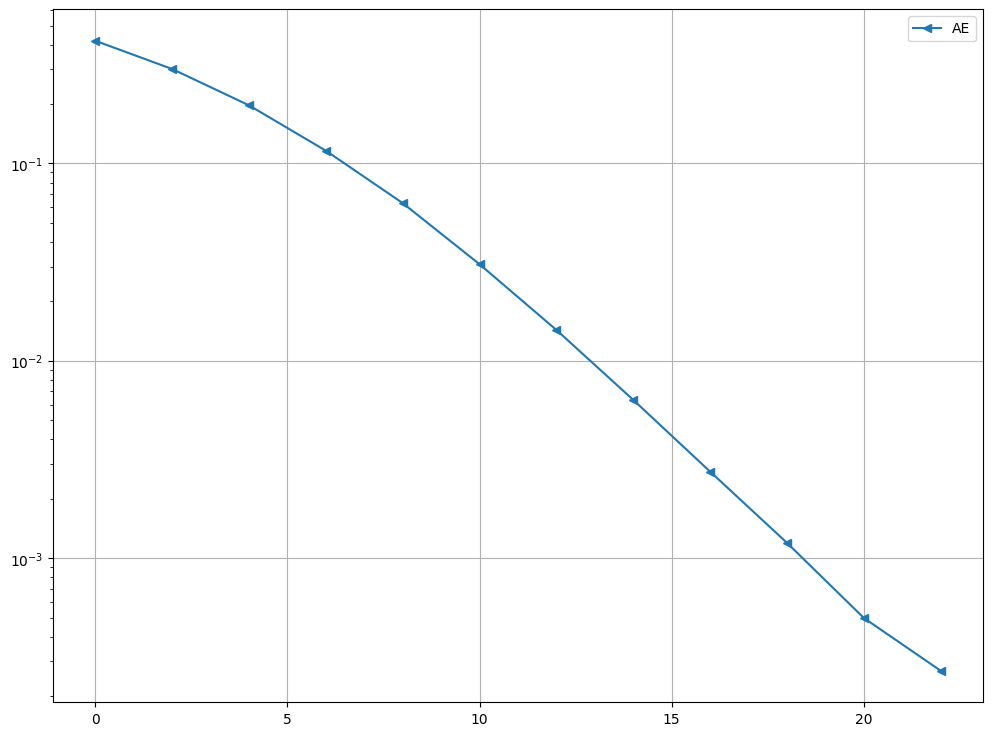

In [7]:
plt.figure(figsize=(12, 9))

plt.semilogy(np.arange(0, 24, 2), SER, "-<", label="AE")
plt.grid()
plt.legend()

Text(0.5, 1.0, 'Tx sym, Ant 2, T2')

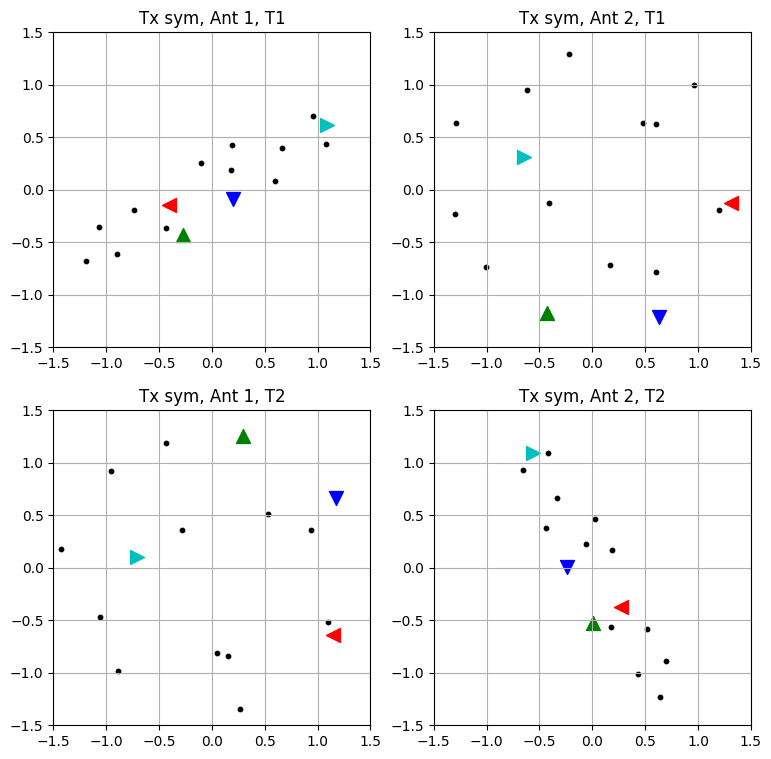

In [8]:
num_mess = 400
messages = np.arange(M)
messages = np.tile(messages, num_mess)
test_labels = to_categorical(messages)

ch_real = (torch.randn((M * num_mess, 2, 1)) / np.sqrt(2)).to(device)
ch_imag = (torch.randn((M * num_mess, 2, 1)) / np.sqrt(2)).to(device)

test_data = torch.from_numpy(test_labels).to(device)
test_label = torch.from_numpy(messages).to(device)

transmitted_signals = encoder(test_data).to("cpu").detach().numpy()

s1 = transmitted_signals[:, 0] + 1j * transmitted_signals[:, 4]
s2 = transmitted_signals[:, 1] + 1j * transmitted_signals[:, 5]
s3 = transmitted_signals[:, 2] + 1j * transmitted_signals[:, 6]
s4 = transmitted_signals[:, 3] + 1j * transmitted_signals[:, 7]

a = 0  #### rotation angles should be carefully find for every different realization
s1 = s1 * np.exp(1j * np.pi * a / 4)
s2 = s2 * np.exp(1j * np.pi * a / 4)
s3 = s3 * np.exp(1j * np.pi * a / 4)
s4 = s4 * np.exp(1j * np.pi * a / 4)

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
ax1 = axs[0, 0]
ax2 = axs[0, 1]
ax3 = axs[1, 0]
ax4 = axs[1, 1]
for axe in [ax1, ax2, ax3, ax4]:
    axe.grid(True)
    axe.set_xlim([-1.5, 1.5])
    axe.set_ylim([-1.5, 1.5])
#     axe.set_xlabel('Real')
#     axe.set_ylabel('Imaginary')


color_map = [
    "r",
    "b",
    "g",
    "r",
    "c",
    "m",
    "y",
    "k",
    "w",
    "r",
    "b",
    "g",
    "r",
    "c",
    "m",
    "y",
    "k",
    "w",
]
marker_style = [
    "o",
    "v",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    "*",
    "h",
    "H",
    "D",
    "d",
    "P",
    "X",
    "o",
]

ax1.scatter(s1[0:16].real, s1[0:16].imag, c="k", s=10)
ax3.scatter(s2[0:16].real, s2[0:16].imag, c="k", s=10)
ax2.scatter(s3[0:16].real, s3[0:16].imag, c="k", s=10)
ax4.scatter(s4[0:16].real, s4[0:16].imag, c="k", s=10)
for i in np.arange(1, 5):
    ax1.scatter(s1[i].real, s1[i].imag, c=color_map[i], s=100, marker=marker_style[i])
    ax3.scatter(s2[i].real, s2[i].imag, c=color_map[i], s=100, marker=marker_style[i])
    ax2.scatter(s3[i].real, s3[i].imag, c=color_map[i], s=100, marker=marker_style[i])
    ax4.scatter(s4[i].real, s4[i].imag, c=color_map[i], s=100, marker=marker_style[i])

ax1.set_title("Tx sym, Ant 1, T1")
ax2.set_title("Tx sym, Ant 2, T1")
ax3.set_title("Tx sym, Ant 1, T2")
ax4.set_title("Tx sym, Ant 2, T2")